# Распознавание текста при помощи OCR библиотеки

Импорт библиотек

In [1]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-rus
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,255 kB/s)
debconf: unable to initia

In [16]:
import requests
import glob
import re
import pytesseract
import cv2
from urllib.parse import urlencode
from zipfile import ZipFile
import zipfile

Загрузка архива с яндекс диска

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/kVdTaY8TuGvBkw' 

In [ ]:
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [ ]:
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:  
    f.write(download_response.content)

Распаковка архива

In [ ]:
archive = 'downloaded_file.zip'
zip_file = ZipFile(archive)
with zipfile.ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

Чтение текста с фотографий при помощи tesseract

In [ ]:
data = ''
config = r'--oem 3 --pcm 6'
for img in glob.glob('/content/ DataForOCR/*.png'):
        image = cv2.imread(img)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        string = pytesseract.image_to_string(gray, lang='rus', config=config)
        data += string

In [ ]:
text = re.sub('[^А-Я\s]+', '', data)
text.replace('\n', '').replace('\x0c', '')

# Распознавание текста при помощи нейронной сети

Импорт библиотек

In [ ]:
!pip install split-folders

In [74]:
import os
import numpy as np
import tensorflow as tf
import splitfolders
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

Функция преобразования картинок

In [32]:
def make_background(img):
    image=img
    file_without_extension = image.split('.')[0]
    image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    trans_mask = image[:, :, 3] == 0
    image[trans_mask] = [255, 255, 255, 255]
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(file_without_extension + '.jpeg', new_img)
    os.remove(img)

Загрузка Dataset'а

In [ ]:
!git clone https://github.com/GregVial/CoMNIST.git

In [ ]:
!unzip /content/CoMNIST/images/Cyrillic.zip

In [34]:
!rm -rf /content/Cyrillic/I

In [33]:
for img in glob.glob('/content/Cyrillic/*/*.png'):
    make_background(img)

In [35]:
splitfolders.ratio('/content/Cyrillic', '/content/Cyrillic-split', ratio=(0.7, 0.2, 0.1), seed=2, group_prefix=None)

Copying files: 15233 files [00:01, 8049.67 files/s]


Создаем Tensorflow Dataset'ы

In [36]:
batch_size=256
image_size=(278, 278)

Наборы данных для обучения и проверки

In [38]:
train_dataset = image_dataset_from_directory('/content/Cyrillic-split/train/',                                             
                                             seed=42,                                             
                                             batch_size=batch_size,
                                             image_size=image_size)

validation_dataset = image_dataset_from_directory('/content/Cyrillic-split/val/',                                            
                                             seed=42,                                             
                                             batch_size=batch_size,
                                             image_size=image_size)

test_dataset = image_dataset_from_directory('/content/Cyrillic-split/test/',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 10647 files belonging to 33 classes.
Found 3032 files belonging to 33 classes.
Found 1554 files belonging to 33 classes.


Названия классов в наборе данных

In [ ]:
class_names = train_dataset.class_names
class_names

Примеры изображений

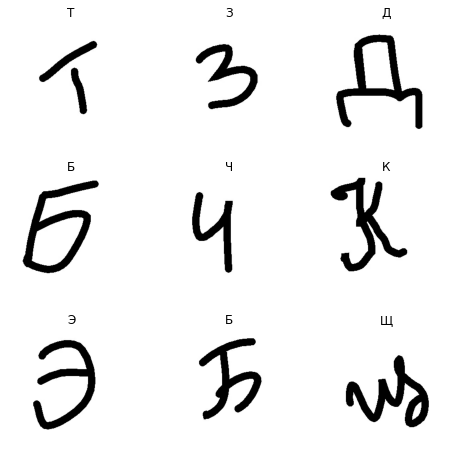

In [40]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
test_dataset.class_names

Настраиваем производительность TensorFlow DataSet'ов

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Создаем нейронную сеть

In [52]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', 
                 input_shape=(278, 278, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(33, activation='softmax'))

Компилируем модель

In [53]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Обучаем нейронную сеть

In [58]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=10,
                    verbose=2)

Epoch 1/10
42/42 - 36s - loss: 0.1455 - accuracy: 0.9529 - val_loss: 0.4439 - val_accuracy: 0.8806 - 36s/epoch - 852ms/step
Epoch 2/10
42/42 - 35s - loss: 0.1124 - accuracy: 0.9636 - val_loss: 0.5102 - val_accuracy: 0.8813 - 35s/epoch - 842ms/step
Epoch 3/10
42/42 - 35s - loss: 0.0956 - accuracy: 0.9696 - val_loss: 0.4999 - val_accuracy: 0.8849 - 35s/epoch - 844ms/step
Epoch 4/10
42/42 - 35s - loss: 0.0779 - accuracy: 0.9760 - val_loss: 0.5016 - val_accuracy: 0.8859 - 35s/epoch - 842ms/step
Epoch 5/10
42/42 - 36s - loss: 0.0699 - accuracy: 0.9767 - val_loss: 0.4829 - val_accuracy: 0.8915 - 36s/epoch - 846ms/step
Epoch 6/10
42/42 - 36s - loss: 0.0528 - accuracy: 0.9822 - val_loss: 0.4921 - val_accuracy: 0.8889 - 36s/epoch - 852ms/step
Epoch 7/10
42/42 - 36s - loss: 0.0436 - accuracy: 0.9852 - val_loss: 0.5533 - val_accuracy: 0.8958 - 36s/epoch - 848ms/step
Epoch 8/10
42/42 - 35s - loss: 0.0470 - accuracy: 0.9839 - val_loss: 0.5270 - val_accuracy: 0.8898 - 35s/epoch - 842ms/step
Epoch 9/

Оцениваем качетсво обучения сети

In [59]:
scores = model.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 3s 271ms/step - loss: 0.5243 - accuracy: 0.9003


In [60]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.0257


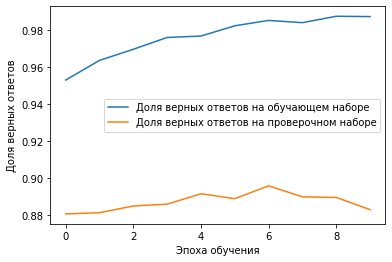

In [61]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

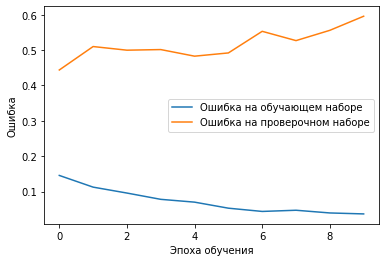

In [62]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Сохраняем обученную нейронную сеть

In [63]:
model.save("Cyrillic.h5")

In [64]:
files.download("Cyrillic.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Распознавание паспортов нейронной сетью

In [ ]:
def emnist_predict(model, image_file):
    img = keras.preprocessing.image.load_img(image_file, target_size=(28, 28), color_mode='grayscale')
    emnist_predict_img(model, img)

In [ ]:
def emnist_predict_img(model, img):
    img_arr = np.expand_dims(img, axis=0)
    img_arr = 1 - img_arr/255.0
    img_arr[0] = np.rot90(img_arr[0], 3)
    img_arr[0] = np.fliplr(img_arr[0])
    img_arr = img_arr.reshape((1, 28, 28, 1))

    predict = model.predict([img_arr])
    result = np.argmax(predict, axis=1)
    return chr(emnist_labels[result[0]])

In [ ]:
def letters_extract(image_file: str, out_size=28):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    output = img.copy()

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        # print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        # hierarchy[i][0]: the index of the next contour of the same level
        # hierarchy[i][1]: the index of the previous contour of the same level
        # hierarchy[i][2]: the index of the first child
        # hierarchy[i][3]: the index of the parent
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            letter_crop = gray[y:y + h, x:x + w]
            # print(letter_crop.shape)

            # Resize letter canvas to square
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                # Enlarge image top-bottom
                # ------
                # ======
                # ------
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                # Enlarge image left-right
                # --||--
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            # Resize letter to 28x28 and add letter and its X-coordinate
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))

    # Sort array in place by X-coordinate
    letters.sort(key=lambda x: x[0], reverse=False)

    # cv2.imshow("Input", img)
    # # cv2.imshow("Gray", thresh)
    # cv2.imshow("Enlarged", img_erode)
    # cv2.imshow("Output", output)
    # cv2.imshow("0", letters[0][2])
    # cv2.imshow("1", letters[1][2])
    # cv2.imshow("2", letters[2][2])
    # cv2.imshow("3", letters[3][2])
    # cv2.imshow("4", letters[4][2])
    # cv2.waitKey(0)
    return letters


In [ ]:
image_file = "text.png"
img = cv2.imread(image_file)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

# Get contours
contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

output = img.copy()

for idx, contour in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    # print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
    # hierarchy[i][0]: the index of the next contour of the same level
    # hierarchy[i][1]: the index of the previous contour of the same level
    # hierarchy[i][2]: the index of the first child
    # hierarchy[i][3]: the index of the parent
    if hierarchy[0][idx][3] == 0:
        cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)

In [ ]:
s_out = img_to_str(model, "hello_world.png")
print(s_out)

In [ ]:
data = ''
config = r'--oem 3 --pcm 6'
for img in glob.glob('/content/ DataForOCR/*.png'):
        image = cv2.imread(img)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        string = model.predict(trainX)
        data += string